In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.pandas.set_option('display.max_columns',None)

In [3]:
train_data = pd.read_csv("../data/train_smote_processed_data.csv")
train_data.shape

(27986, 18)

In [4]:
test_data = pd.read_csv("../data/test_processed_data.csv")
test_data.shape

(11994, 18)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot

In [6]:
from sklearn import metrics
def model_compare(model_name,model,y_test,y_pred, roc_auc = None):
    y_score = accuracy_score(y_test, y_pred)
    if roc_auc:
        fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr_dt, tpr_dt) 
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision': metrics.precision_score(y_test, y_pred),
                        'Recall'   : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC'  : roc_auc
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model_name] 
    return df_metrics

In [7]:
def selecting_optimal_thresholds(model,x_test,y_test):
    model_probs = model.predict_proba(x_test)
    model_probs = model_probs[:, 1]
    model_auc   = roc_auc_score(y_test, model_probs)

    fpr, tpr, thresholds = roc_curve(y_test, model_probs)

    gmeans = sqrt(tpr * (1-fpr))
    
    ix = argmax(gmeans)
    # ix = 25
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, model_probs)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()

In [8]:

def draw_confusion_matrix_binary(y_test,y_pred,model=None):
    matrixdata = confusion_matrix(y_test, y_pred, labels=[1,0])
    group_names  = ['TP','FN','FP','TN'] # ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                matrixdata.flatten()]
    categories = ['Zero', 'One']
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrixdata, annot=labels, cmap='Blues' , fmt='') # cmap='Blues' , fmt=''   categories=categories,cmap='binary'
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Actual vs. Predicted Confusion Matrix')
    plt.show()
    
    print(f" TPR  => {matrixdata[0][0]/(matrixdata[0][0] + matrixdata[0][1])} \n")
    print(f" FPR  => {(1 - (matrixdata[1][1]/(matrixdata[1][0] + matrixdata[1][1])))} \n")
    print(classification_report(y_test, y_pred, labels=[1,0]))

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
from imblearn.over_sampling import SVMSMOTE
from sklearn import svm
oversample = SVMSMOTE(
    sampling_strategy='auto',
    random_state=303,
    k_neighbors=5,
    m_neighbors=10,
    n_jobs=1,
    svm_estimator = svm.SVC(kernel='')
)

In [14]:
x = train_data.drop(['y'],axis =1).values
scaler.fit(x)
x = scaler.transform(x)
y = train_data['y'].values
x_train, y_train = oversample.fit_resample(x, y)
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.3, random_state=303)

In [15]:
x_test = test_data.drop(['y'],axis =1).values
x_test = scaler.transform(x_test)
y_test = test_data['y'].values

## DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
model_dt = DecisionTreeClassifier(random_state=303)
np.random.seed(303)
# start = time.time()
param_dist = {'max_depth': [2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[100,200,70, 30],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_dt, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 70}


In [18]:
model_dt = DecisionTreeClassifier(random_state=303,
                                  max_depth=7, 
                                  criterion = 'entropy', 
                                  min_samples_leaf=70 )
model_dt.fit(x_train, y_train)
model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ",model_dt_score_train)
model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

Training score:  0.923356072023479
Testing score:  0.8901117225279306


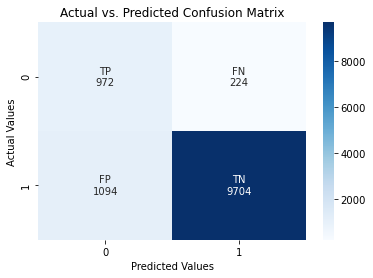

 TPR  => 0.8127090301003345 

 FPR  => 0.10131505834413779 

              precision    recall  f1-score   support

           1       0.47      0.81      0.60      1196
           0       0.98      0.90      0.94     10798

    accuracy                           0.89     11994
   macro avg       0.72      0.86      0.77     11994
weighted avg       0.93      0.89      0.90     11994



,Decision Tree
Accuracy,0.890112
Precision,0.470474
Recall,0.812709
F1 Score,0.595953
ROC AUC,0.855697


In [19]:
y_pred = model_dt.predict(x_test)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_dt = model_compare("Decision Tree",model_dt, y_test, y_pred, True )
metrix_dt

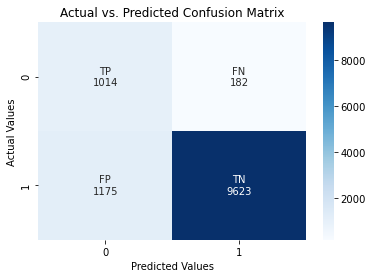

 TPR  => 0.8478260869565217 

 FPR  => 0.10881644749027597 

              precision    recall  f1-score   support

           1       0.46      0.85      0.60      1196
           0       0.98      0.89      0.93     10798

    accuracy                           0.89     11994
   macro avg       0.72      0.87      0.77     11994
weighted avg       0.93      0.89      0.90     11994



,Decision Tree
Accuracy,0.886860
Precision,0.463225
Recall,0.847826
F1 Score,0.599114
ROC AUC,0.869505


In [45]:
y_pred = model_dt.predict(x_test)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_dt = model_compare("Decision Tree",model_dt, y_test, y_pred, True )
metrix_dt

### SELECTING OPTIMAL Thresholds

Best Threshold=0.271429, G-Mean=0.877


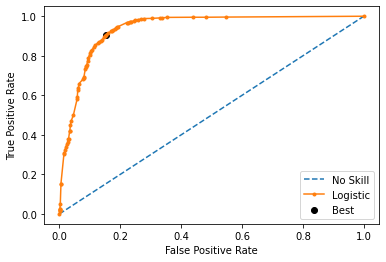

Best Threshold=0.537634, F-Score=0.598


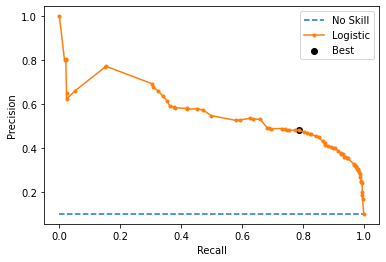

In [20]:
selecting_optimal_thresholds(model_dt,x_test,y_test)

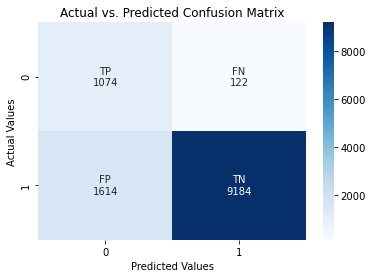

 TPR  => 0.8979933110367893 

 FPR  => 0.14947212446749403 

              precision    recall  f1-score   support

           1       0.40      0.90      0.55      1196
           0       0.99      0.85      0.91     10798

    accuracy                           0.86     11994
   macro avg       0.69      0.87      0.73     11994
weighted avg       0.93      0.86      0.88     11994



,Decision Tree ROC
Accuracy,0.855261
Precision,0.399554
Recall,0.897993
F1 Score,0.553038
ROC AUC,0.874261


In [21]:
y_pred = (model_dt.predict_proba(x_test)[:,1] >= 0.271429).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_dt = model_compare("Decision Tree ROC ",model_dt, y_test, y_pred,True  )
roc_metrix_dt

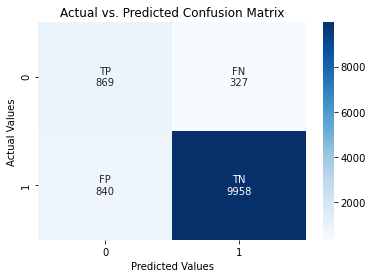

 TPR  => 0.7265886287625418 

 FPR  => 0.07779218373772923 

              precision    recall  f1-score   support

           1       0.51      0.73      0.60      1196
           0       0.97      0.92      0.94     10798

    accuracy                           0.90     11994
   macro avg       0.74      0.82      0.77     11994
weighted avg       0.92      0.90      0.91     11994



,Decision Tree ROC
Accuracy,0.902701
Precision,0.508484
Recall,0.726589
F1 Score,0.598279
ROC AUC,0.824398


In [34]:
y_pred = (model_dt.predict_proba(x_test)[:,1] >= 0.750725).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_dt = model_compare("Decision Tree ROC ",model_dt, y_test, y_pred,True  )
roc_metrix_dt

In [30]:
metrix_dt

,Decision Tree
Accuracy,0.886860
Precision,0.463225
Recall,0.847826
F1 Score,0.599114
ROC AUC,0.869505


## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
model_rf = RandomForestClassifier(random_state=303)

In [24]:
param_dist = {'max_depth': [3,4,5,7,8],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': None}


In [35]:
print(cv_rf.best_estimator_)

RandomForestClassifier(max_depth=8, max_features=None, random_state=303)


In [25]:
model_rf.set_params(criterion    = 'gini',
                    max_features = None, 
                    max_depth    = 8,
                    bootstrap    = True,
                    n_estimators = 1400,
                    warm_start   = False, 
                    oob_score    = False
                   )


RandomForestClassifier(max_depth=8, max_features=None, n_estimators=1400,
                       random_state=303)

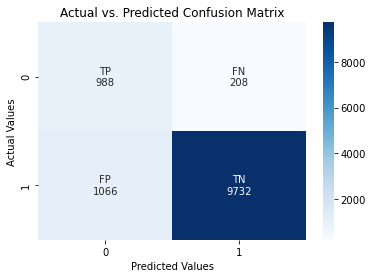

 TPR  => 0.8260869565217391 

 FPR  => 0.09872198555288014 

              precision    recall  f1-score   support

           1       0.48      0.83      0.61      1196
           0       0.98      0.90      0.94     10798

    accuracy                           0.89     11994
   macro avg       0.73      0.86      0.77     11994
weighted avg       0.93      0.89      0.91     11994



,Random Forest
Accuracy,0.893780
Precision,0.481013
Recall,0.826087
F1 Score,0.608000
ROC AUC,0.863682


In [26]:
model_rf.fit(x_train, y_train)
y_pred= model_rf.predict(x_test)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_rf = model_compare("Random Forest",model_rf, y_test, y_pred, True)
metrix_rf

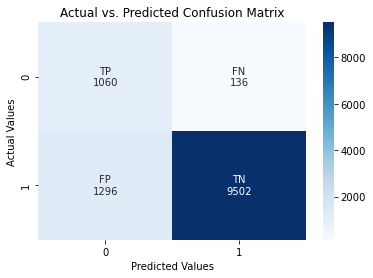

 TPR  => 0.8862876254180602 

 FPR  => 0.1200222263382108 

              precision    recall  f1-score   support

           1       0.45      0.89      0.60      1196
           0       0.99      0.88      0.93     10798

    accuracy                           0.88     11994
   macro avg       0.72      0.88      0.76     11994
weighted avg       0.93      0.88      0.90     11994



,Random Forest
Accuracy,0.880607
Precision,0.449915
Recall,0.886288
F1 Score,0.596847
ROC AUC,0.883133


In [37]:
model_rf.fit(x_train, y_train)
y_pred= model_rf.predict(x_test)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_rf = model_compare("Random Forest",model_rf, y_test, y_pred, True)
metrix_rf

### SELECTING OPTIMAL Thresholds

Best Threshold=0.208550, G-Mean=0.885


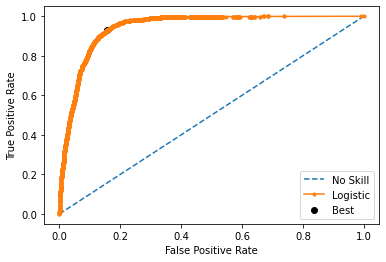

Best Threshold=0.637820, F-Score=0.617


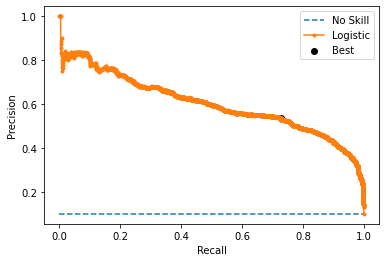

In [27]:
selecting_optimal_thresholds(model_rf,x_test,y_test)

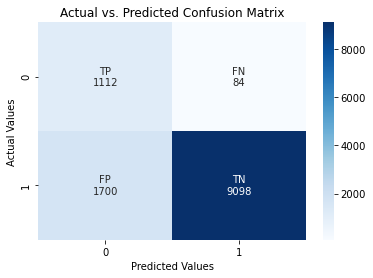

 TPR  => 0.9297658862876255 

 FPR  => 0.15743656232635672 

              precision    recall  f1-score   support

           1       0.40      0.93      0.55      1196
           0       0.99      0.84      0.91     10798

    accuracy                           0.85     11994
   macro avg       0.69      0.89      0.73     11994
weighted avg       0.93      0.85      0.88     11994



,Random Forest ROC
Accuracy,0.851259
Precision,0.395448
Recall,0.929766
F1 Score,0.554890
ROC AUC,0.886165


In [28]:
y_pred = (model_rf.predict_proba(x_test)[:,1] >= 0.208550).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_rf = model_compare("Random Forest ROC ",model_rf, y_test, y_pred,True)
roc_metrix_rf

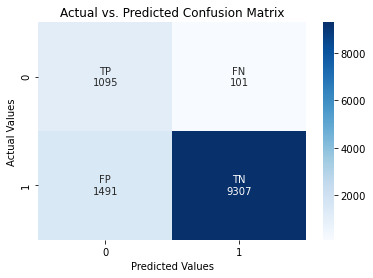

 TPR  => 0.9155518394648829 

 FPR  => 0.13808112613446932 

              precision    recall  f1-score   support

           1       0.42      0.92      0.58      1196
           0       0.99      0.86      0.92     10798

    accuracy                           0.87     11994
   macro avg       0.71      0.89      0.75     11994
weighted avg       0.93      0.87      0.89     11994



,Random Forest ROC
Accuracy,0.867267
Precision,0.423434
Recall,0.915552
F1 Score,0.579059
ROC AUC,0.888735


In [43]:
y_pred = (model_rf.predict_proba(x_test)[:,1] >= 0.411206).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_rf = model_compare("Random Forest ROC ",model_rf, y_test, y_pred,True)
roc_metrix_rf

In [42]:
metrix_rf

,Random Forest
Accuracy,0.880607
Precision,0.449915
Recall,0.886288
F1 Score,0.596847
ROC AUC,0.883133


In [44]:
metrics_bn_new = pd.concat([metrix_dt, roc_metrix_dt, metrix_rf, roc_metrix_rf], axis=1) #  metrix_nb,  metrix_GB, , metrix_xgboost
metrics_bn_new

,Decision Tree,Decision Tree ROC,Random Forest,Random Forest ROC
Accuracy,0.886860,0.902701,0.880607,0.867267
Precision,0.463225,0.508484,0.449915,0.423434
Recall,0.847826,0.726589,0.886288,0.915552
F1 Score,0.599114,0.598279,0.596847,0.579059
ROC AUC,0.869505,0.824398,0.883133,0.888735


In [29]:
metrics_bn_new = pd.concat([metrix_dt, roc_metrix_dt, metrix_rf, roc_metrix_rf], axis=1) #  metrix_nb,  metrix_GB, , metrix_xgboost
metrics_bn_new

,Decision Tree,Decision Tree ROC,Random Forest,Random Forest ROC
Accuracy,0.890112,0.855261,0.893780,0.851259
Precision,0.470474,0.399554,0.481013,0.395448
Recall,0.812709,0.897993,0.826087,0.929766
F1 Score,0.595953,0.553038,0.608000,0.554890
ROC AUC,0.855697,0.874261,0.863682,0.886165
